# Setup Enviroment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import distutils.core
import sys
import os
import numpy as np
import torch
from tqdm import tqdm
import cv2
from PIL import Image
import pickle
import torchvision
import json
from scipy.special import softmax

!pip install torchmetrics &> /dev/null
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchmetrics.detection import IntersectionOverUnion

device = "cuda" if torch.cuda.is_available() else "cpu"

## Import our project

In [ ]:
!git clone https://github.com/uonat/SS2023_DI-Lab_Precitaste.git &> /dev/null
%cd SS2023_DI-Lab_Precitaste
%pip install . &> /dev/null

# For CLIP
%pip install ftfy regex &> /dev/null
%pip install git+https://github.com/openai/CLIP.git &> /dev/null

# For VitDet
!git clone 'https://github.com/facebookresearch/detectron2'  &> /dev/null
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])} &> /dev/null
sys.path.insert(0, os.path.abspath('./detectron2'))

#import functions
from dataset.RPCDataset import RPCDataset
from models.CLIP import load_model as load_clip, tokenize_text
from models.VitDet import load_model as load_VitDet
from utilities.non_maximum_suppression import nms
from utilities.bbox_postprocess import eliminate_boxes


/content/SS2023_DI-Lab_Precitaste


## Models

### VitDet

In [ ]:
model_obj_proposer_model_path = "/content/drive/MyDrive/ApplicationProject/Models/model2.pkl"
model_obj_proposer_config_path ="/content/SS2023_DI-Lab_Precitaste/detectron2/projects/ViTDet/configs/LVIS/mask_rcnn_vitdet_h_100ep.py"
model_obj_proposer = load_VitDet(model_obj_proposer_model_path,model_obj_proposer_config_path)
model_obj_proposer.to(device)
model_obj_proposer.eval()
print()

[07/21 04:15:35 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/ApplicationProject/Models/model2.pkl ...



### CLIP

In [ ]:
clip_ViT_L_14, clip_ViT_L_14_preprocess = load_clip("ViT-L/14",device)
clip_ViT_L_14.eval()
print()

100%|████████████████████████████████████████| 890M/890M [00:06<00:00, 152MiB/s]


## Import Datasets

### RPC dataset

In [ ]:
!mkdir '/content/retail_product_checkout'
!mkdir '/content/retail_product_checkout/val2019'
!unzip -q -j "/content/drive/MyDrive/ApplicationProject/Data/retail-product-checkout-dataset.zip" "val2019/*" -d '/content/retail_product_checkout/val2019'
!unzip -q -j "/content/drive/MyDrive/ApplicationProject/Data/retail-product-checkout-dataset.zip" "instances_val2019.json" -d '/content/retail_product_checkout'

RPC_val_dataset_path = "/content/retail_product_checkout"
RPC_val_dataset = RPCDataset(RPC_val_dataset_path, "val")

In [ ]:
RPC_all_labels = set()
for i in range(RPC_val_dataset.get_num_imgs()):
  annots  = RPC_val_dataset.get_annots_by_img_id(i, key_for_category='sku_name')
  for annot in annots:
    RPC_all_labels.add('_'.join(annot[1].split('_')[1:]))
RPC_all_labels = list(RPC_all_labels)
print(RPC_all_labels)

RPC_all_labels_a_an = []
for i in range(len(RPC_all_labels)):
  label_in_writing = ' '.join(RPC_all_labels[i].split('_'))
  if RPC_all_labels[i][0] in ('a', 'e', 'i', 'o', 'u'):
    RPC_all_labels_a_an.append( "an " + label_in_writing)
  else:
    RPC_all_labels_a_an.append( "a " + label_in_writing)
print(RPC_all_labels_a_an)

['alcohol', 'puffed_food', 'personal_hygiene', 'tissue', 'candy', 'seasoner', 'stationery', 'instant_noodles', 'dried_fruit', 'gum', 'dessert', 'drink', 'chocolate', 'milk', 'instant_drink', 'canned_food', 'dried_food']
['an alcohol', 'a puffed food', 'a personal hygiene', 'a tissue', 'a candy', 'a seasoner', 'a stationery', 'an instant noodles', 'a dried fruit', 'a gum', 'a dessert', 'a drink', 'a chocolate', 'a milk', 'an instant drink', 'a canned food', 'a dried food']


### COCO dataset

In [ ]:
!cp /content/drive/MyDrive/ApplicationProject/Data/coco/annotations/instances_val2017.json /content/
!cp /content/drive/MyDrive/ApplicationProject/Data/coco/annotations/instances_train2017.json /content/
!cp -R /content/drive/MyDrive/ApplicationProject/Data/coco/val2017 /content/

In [ ]:
from pycocotools.coco import COCO

class CocoDataset:
  def __init__(self, parent_dir, split = 'val'):
    if  split ==  'val':
      self.imgs_dir = os.path.join(parent_dir,"val2017")
      annot_path = os.path.join(parent_dir,"instances_val2017.json")
    elif  split ==  'train':
      self.imgs_dir = os.path.join(parent_dir,"train2017")
      annot_path = os.path.join(parent_dir,"instances_train2017.json")
    else:
      raise ValueError("Only val and train are implemented")

    coco = COCO(annot_path)
    image_ids = coco.getImgIds()
    images = coco.loadImgs(image_ids)

    self.category_dict = {category['id']: category['name'] for category in coco.dataset['categories']}
    #self.categories = ['_'.join(category_dict[i].split(' ')) for i in category_dict.keys()]

    self.list_names =  []
    self.list_annots =  []  #[([xywh],5),...,([xywh],3)]

    for i in images:
      self.list_names.append(i['file_name'])
      annots = coco.loadAnns(coco.getAnnIds(imgIds=i['id']))
      list_annots_single =  []
      for j in annots:
        list_annots_single.append((j['bbox'],j['category_id']))
      self.list_annots.append(list_annots_single)

  def get_num_imgs(self):
    return len(self.list_names)

  def get_img_path_by_id(self,i):
    return os.path.join(self.imgs_dir,self.list_names[i])

  def get_annots_by_img_id(self,i, **kwargs):
    return self.list_annots[i]


In [ ]:
Coco_val_dataset = CocoDataset("/content")

loading annotations into memory...
Done (t=0.94s)
creating index...
index created!


In [ ]:
#One Ground Truth annotation problem fix
"""
for i in tqdm(range(Coco_val_dataset.get_num_imgs())):
  annots = Coco_val_dataset.get_annots_by_img_id(i)
  for annot in annots:
    x1,y1,w,h = annot[0]
    x2,y2 = x1+w,y1+h
    x1,y1,x2,y2 = map(int,[x1,y1,x2,y2])          # Due to this
    if x2 <= x1 or y2 <= y1 or x1 < 0 or y1 < 0:  # Also add max check!
      print("\nError in i = {}".format(i))        #>>> Error in i = 556
      print(x1,y1,x2,y2)                          #>>> 205 381 210 381
"""
#Coco_val_dataset.get_annots_by_img_id(556)[20]
#print(Coco_val_dataset.list_annots[556][20])           #>>> ([205.18, 381.06, 5.45, 0.86], 35)
Coco_val_dataset.list_annots[556][20][0][3] = 1.0
print(Coco_val_dataset.get_annots_by_img_id(556)[20])   #>>> ([205.18, 381.06, 5.45, 1.0], 35)

([205.18, 381.06, 5.45, 1.0], 35)


In [ ]:
#TODO: REMOVE THE INSTANCES WITH 0 OBJECTS!!
coco_no_objects_image_file_names = []
coco_no_objects_image_ids =  []
for i in range(Coco_val_dataset.get_num_imgs()):
  annots = Coco_val_dataset.get_annots_by_img_id(i)
  if len(annots) == 0:
    coco_no_objects_image_file_names.append(Coco_val_dataset.list_names[i])
    coco_no_objects_image_ids.append(i)

# Utility Functions


In [ ]:
def get_obj_proposels(img,rescale_factor):
  global device, model_obj_proposer
  H,W,_ = img.shape
  resize_trans = torchvision.transforms.Resize((int(H/rescale_factor),int(W/rescale_factor)),antialias=True)
  batch = [{'image':resize_trans(torch.from_numpy(img).movedim(-1,0)).to(device)}]
  with torch.no_grad():
    model_result = model_obj_proposer(batch)
  pred_boxes = model_result[0]['instances'].pred_boxes.tensor #.to(torch.int)
  pred_boxes = (pred_boxes * rescale_factor).tolist()
  pred_scores = model_result[0]['instances'].scores.tolist()
  return pred_boxes,pred_scores

def get_all_obj_proposels(dataset,rescale_factor):
  all_obj_proposels = []
  for i in tqdm(range(dataset.get_num_imgs())):
    img_path = dataset.get_img_path_by_id(i)
    img = cv2.imread(img_path)
    pred_boxes,pred_scores = get_obj_proposels(img,rescale_factor)
    all_obj_proposels.append((pred_boxes,pred_scores))
  return all_obj_proposels

def run_nms_all_images(all_obj_proposels,nms_th):
  all_obj_proposels_nms = []
  for pair in all_obj_proposels:
    pred_boxes,pred_scores = pair
    picked_boxes, picked_score = nms(pred_boxes,pred_scores,nms_th)
    all_obj_proposels_nms.append((picked_boxes, picked_score))
  return all_obj_proposels_nms

def  h_w_of_dataset(dataset): #actually this info saved inside database classes
  H_W_list = []
  for i in range(dataset.get_num_imgs()):
    H,W,_ = cv2.imread(dataset.get_img_path_by_id(i)).shape
    H_W_list.append((H,W))
  return H_W_list

def run_eliminate_boxes_all_images(all_obj_proposels_nms,H_W_list,elim_box_area_th,elim_box_eps,small_obj_size,score_th):
  all_obj_proposels_eliminate_boxes = []
  for pair,(H,W) in zip(all_obj_proposels_nms,H_W_list):
    picked_boxes, picked_score = pair
    remaining_boxes, remaining_boxes_indices = eliminate_boxes(picked_boxes, H, W, area_thres=elim_box_area_th, eps=elim_box_eps, return_bbox_indices=True)

    # Discard very small objects and look at the scores (discard more boxes if needed in case of too low scores)
    small_obj_th_w, small_obj_th_h = small_obj_size
    for ind_del, (val1, val2) in reversed(list(enumerate(zip(remaining_boxes, remaining_boxes_indices)))):
      x1,y1,x2,y2 = val1
      if (x2 - x1) < small_obj_th_w or (y2 - y1) < small_obj_th_h or \
      picked_score[remaining_boxes_indices[ind_del]] < score_th :
        del remaining_boxes[ind_del]
        del remaining_boxes_indices[ind_del]
    remaining_scores = [picked_score[ind_rem] for ind_rem in remaining_boxes_indices]

    all_obj_proposels_eliminate_boxes.append((remaining_boxes, remaining_scores))
  return all_obj_proposels_eliminate_boxes

In [ ]:
def prepare_targets(in_dataset, dataset_name="", key_for_category='sku_class',no_labels=False):
  if dataset_name == "RPC":
    global RPC_all_labels
  targets = []
  for i in range(in_dataset.get_num_imgs()):
    annots = in_dataset.get_annots_by_img_id(i, key_for_category=key_for_category)
    boxes = torch.empty(size=(len(annots), 4))
    labels = []
    for annot_ind, annot in enumerate(annots):
      x1,y1,w,h = annot[0]
      x2,y2 = x1+w,y1+h
      boxes[annot_ind] = torch.Tensor([x1,y1,x2,y2])
      if no_labels:
        labels.append(0)
      elif dataset_name == "RPC":
        labels.append(RPC_all_labels.index(annot[1]))
      else:
        labels.append(annot[1])
    targets.append({"boxes": boxes, "labels": torch.tensor(labels, dtype=torch.int)})
  return targets

def prepare_preds(all_obj_proposels, no_labels=False):
  preds = []
  if no_labels:
    for pair in all_obj_proposels:
      preds.append({"boxes": torch.Tensor(pair[0]).view(len(pair[0]),4),"scores": torch.Tensor(pair[1]),"labels": torch.IntTensor([0]*len(pair[1]))})
    return preds

In [ ]:
def get_crop_embedding(img_crop):
  global device, clip_ViT_L_14, clip_ViT_L_14_preprocess
  img_p = clip_ViT_L_14_preprocess(Image.fromarray(img_crop.copy())).unsqueeze(0).to(device)
  with torch.no_grad():
    img_crop_features = clip_ViT_L_14.encode_image(img_p)
  return img_crop_features.cpu().numpy().tolist()[0]

def get_all_crop_embeddings(dataset,all_obj_proposels):
  all_image_embeddings = []
  for i in tqdm(range(dataset.get_num_imgs())):
    img_path = dataset.get_img_path_by_id(i)
    img = cv2.imread(img_path)
    image_embeddings = []
    for crop_proposel in all_obj_proposels[i]:
      x1,y1,x2,y2 = map(int,crop_proposel)
      if x2 <= x1 or y2 <= y1 or x1 < 0 or y1 < 0: #Also add max check!
        print("Error in i = {}".format(i))
        continue
      cropped_img = cv2.cvtColor(img[y1:y2,x1:x2], cv2.COLOR_BGR2RGB)
      image_embeddings.append(get_crop_embedding(cropped_img))
    all_image_embeddings.append(image_embeddings)
  return all_image_embeddings
"""
def extract_gt_bboxes(dataset): # Simillar to prepare_targets: Don't use!
  all_obj_gt_bboxes = []
  for i in tqdm(range(dataset.get_num_imgs())):
    annots = dataset.get_annots_by_img_id(i, key_for_category='sku_name')
    image_obj_gt_bboxes = []
    for annot in annots:
      x1,y1,w,h = map(int,annot[0])
      x2,y2 = x1+w,y1+h
      image_obj_gt_bboxes.append([x1,y1,x2,y2])
    all_obj_gt_bboxes.append(image_obj_gt_bboxes)
  return all_obj_gt_bboxes
"""
print()

## Metric

In [ ]:
metric_mAP = MeanAveragePrecision(box_format='xyxy', iou_type='bbox', class_metrics=False)
metric_IoU = IntersectionOverUnion(box_format='xyxy', iou_threshold=None, class_metrics=False, respect_labels=True)

def print_mAP_IoU(preds, target):
  global metric_mAP, metric_IoU
  metric_mAP.reset()
  metric_IoU.reset()
  print("mAP: ", metric_mAP(preds, target))
  print("IoU: ", metric_IoU(preds, target))
  metric_mAP.reset()
  metric_IoU.reset()

# Evaluations

In [ ]:
Results_path = "/content/drive/MyDrive/ApplicationProject/All_in_One_Results"

## VitDet Evaluation

### Coco

In [ ]:
rescale_factor = 1

nms_th = 0.5
"""
elim_box_area_th = 100000000.0  # Do not eliminate any object based on their area (too big)
elim_box_eps = 0.0              # Only eliminate the object proposals that are fully inside another object proposal
small_obj_size = (0,0)          # Do not eliminate any object based on their area (too small)
score_th = 0                    # Do not eliminate any bounding box based on their objectness score
"""
# modifications for RPC
elim_box_area_th = 0.6
elim_box_eps = 10
small_obj_size = (56,56)
score_th = 0

In [ ]:
output_name = "VITDET_coco_val_all_obj_proposels.pkl"
output_dir = os.path.join(Results_path,output_name)

if not os.path.isfile(output_dir):
  all_obj_proposels = get_all_obj_proposels(Coco_val_dataset,rescale_factor)
  with open(output_dir, "wb") as fp:
    for item in all_obj_proposels: pickle.dump(item, fp)
else:
  with open(output_dir, "rb") as fp:
    all_obj_proposels = [pickle.load(fp) for i in range(Coco_val_dataset.get_num_imgs())]

targets = prepare_targets(Coco_val_dataset, no_labels=True)

preds = prepare_preds(all_obj_proposels, no_labels=True)
print_mAP_IoU(preds, targets)

all_obj_proposels = run_nms_all_images(all_obj_proposels,nms_th)
preds = prepare_preds(all_obj_proposels, no_labels=True)
print_mAP_IoU(preds, targets)

all_obj_proposels = run_eliminate_boxes_all_images(all_obj_proposels,h_w_of_dataset(Coco_val_dataset),elim_box_area_th,elim_box_eps,small_obj_size,score_th)
preds = prepare_preds(all_obj_proposels, no_labels=True)
print_mAP_IoU(preds, targets)

mAP:  {'map': tensor(0.1773), 'map_50': tensor(0.2711), 'map_75': tensor(0.1895), 'map_small': tensor(0.0464), 'map_medium': tensor(0.1623), 'map_large': tensor(0.3579), 'mar_1': tensor(0.0734), 'mar_10': tensor(0.2677), 'mar_100': tensor(0.5271), 'mar_small': tensor(0.2805), 'mar_medium': tensor(0.5697), 'mar_large': tensor(0.7103), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor(0, dtype=torch.int32)}
IoU:  {'iou': tensor(0.0899)}
mAP:  {'map': tensor(0.1825), 'map_50': tensor(0.2894), 'map_75': tensor(0.1906), 'map_small': tensor(0.0484), 'map_medium': tensor(0.1726), 'map_large': tensor(0.3729), 'mar_1': tensor(0.0734), 'mar_10': tensor(0.2699), 'mar_100': tensor(0.5062), 'mar_small': tensor(0.2848), 'mar_medium': tensor(0.5623), 'mar_large': tensor(0.6528), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor(0, dtype=torch.int32)}
IoU:  {'iou': tensor(0.0707)}
mAP:  {'map': tensor(0.1214), 'map_50': tensor(0.1849), 'm

### RPC

In [ ]:
rescale_factor = 4

nms_th = 0.5

elim_box_area_th = 0.6
elim_box_eps = 10
small_obj_size = (56,56)
score_th = 0

In [ ]:
output_name = "VITDET_RPC_val_all_obj_proposels.pkl"
output_dir = os.path.join(Results_path,output_name)

if not os.path.isfile(output_dir):
  all_obj_proposels = get_all_obj_proposels(RPC_val_dataset,rescale_factor)
  with open(output_dir, "wb") as fp:
    for item in all_obj_proposels: pickle.dump(item, fp)
else:
  with open(output_dir, "rb") as fp:
    all_obj_proposels = [pickle.load(fp) for i in range(RPC_val_dataset.get_num_imgs())]

targets = prepare_targets(RPC_val_dataset, no_labels=True)

preds = prepare_preds(all_obj_proposels, no_labels=True)
print_mAP_IoU(preds, targets)

all_obj_proposels = run_nms_all_images(all_obj_proposels,nms_th)
preds = prepare_preds(all_obj_proposels, no_labels=True)
print_mAP_IoU(preds, targets)

all_obj_proposels = run_eliminate_boxes_all_images(all_obj_proposels,h_w_of_dataset(RPC_val_dataset),elim_box_area_th,elim_box_eps,small_obj_size,score_th)
preds = prepare_preds(all_obj_proposels, no_labels=True)
print_mAP_IoU(preds, targets)

mAP:  {'map': tensor(0.3554), 'map_50': tensor(0.4603), 'map_75': tensor(0.4152), 'map_small': tensor(0.), 'map_medium': tensor(2.5859e-05), 'map_large': tensor(0.4719), 'mar_1': tensor(0.0353), 'mar_10': tensor(0.3763), 'mar_100': tensor(0.8623), 'mar_small': tensor(0.), 'mar_medium': tensor(0.4000), 'mar_large': tensor(0.8623), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor(0, dtype=torch.int32)}
IoU:  {'iou': tensor(0.0752)}
mAP:  {'map': tensor(0.4716), 'map_50': tensor(0.6320), 'map_75': tensor(0.5582), 'map_small': tensor(0.), 'map_medium': tensor(2.8494e-05), 'map_large': tensor(0.6405), 'mar_1': tensor(0.0353), 'mar_10': tensor(0.4555), 'mar_100': tensor(0.8102), 'mar_small': tensor(0.), 'mar_medium': tensor(0.3200), 'mar_large': tensor(0.8102), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor(0, dtype=torch.int32)}
IoU:  {'iou': tensor(0.0452)}
mAP:  {'map': tensor(0.6970), 'map_50': tensor(0.9341), 'map_75': 

#### Visualize

In [ ]:
with open(output_dir, "rb") as fp:
  all_obj_proposels = [pickle.load(fp) for i in range(RPC_val_dataset.get_num_imgs())]

In [ ]:
all_obj_proposels = run_nms_all_images(all_obj_proposels,nms_th)

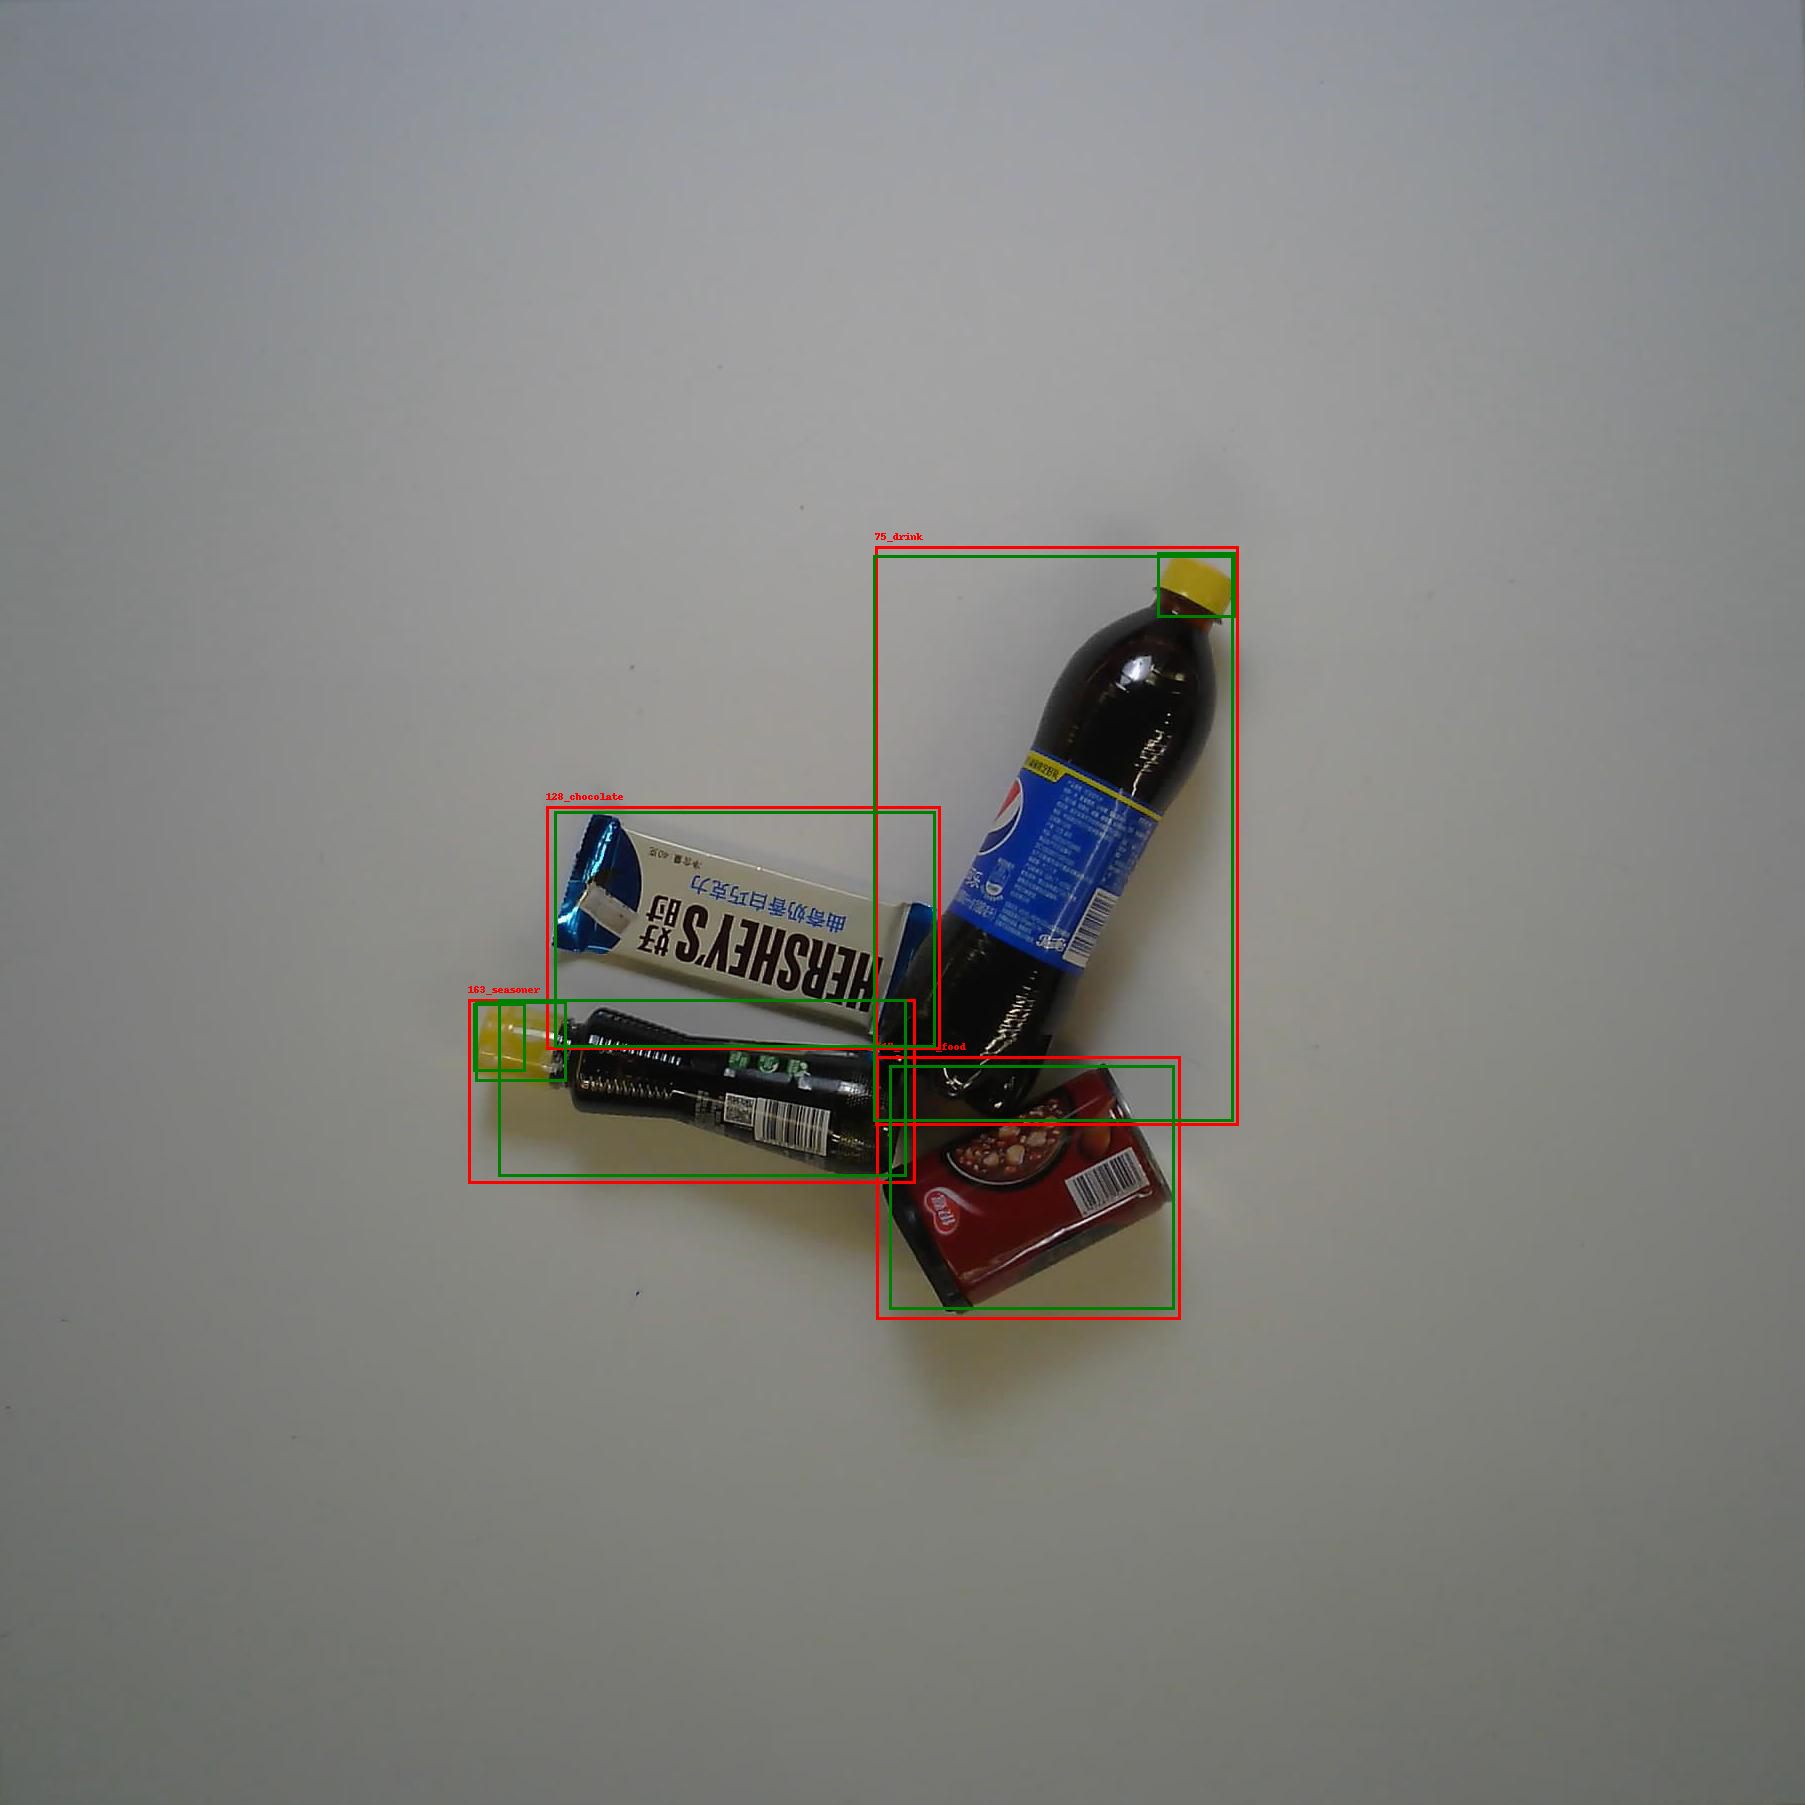

In [ ]:
from PIL import ImageDraw

i = 100

img_path = RPC_val_dataset.get_img_path_by_id(i)
annots = RPC_val_dataset.get_annots_by_img_id(i, key_for_category='sku_name')

an_image_tmp = Image.open(img_path)
draw = ImageDraw.Draw(an_image_tmp)

for annot in annots: #GT
  bbox = annot[0]
  x1,y1,w,h = bbox
  x2,y2 = x1+w,y1+h
  label = annot[1]

  draw.rectangle([x1, y1, x2, y2], outline='red', width=3)

  draw.text((x1, y1-15), label, fill='red')

pair = all_obj_proposels[i]
for bbox in pair[0]: #predictions
  x1,y1,x2,y2 = bbox
  draw.rectangle([x1, y1, x2, y2], outline='green', width=3)

# Display the image
an_image_tmp.show()


## 2nd Stage CLIP Evaluation (with ground truth bounding boxes)

### Text

####  Coco

In [ ]:
output_name = "VITDET_coco_val_all_gt_embeds.pkl"
output_dir = os.path.join(Results_path,output_name)

if not os.path.isfile(output_dir):
  targets = [img["boxes"] for img in prepare_targets(Coco_val_dataset, no_labels=True)]
  all_gt_crop_embeddings = get_all_crop_embeddings(Coco_val_dataset,targets)
  with open(output_dir, "wb") as fp:
    for item in all_gt_crop_embeddings: pickle.dump(item, fp)
else:
  with open(output_dir, "rb") as fp:
    all_gt_crop_embeddings = [pickle.load(fp) for i in range(Coco_val_dataset.get_num_imgs())]

In [ ]:
number_to_key = []
Coco_all_labels = []

for key, value in Coco_val_dataset.category_dict.items():
  number_to_key.append(key)
  Coco_all_labels.append(value)

In [ ]:
#text embeddings
template_texts = ["{}", "A photo of a {}.", "This is a photo of {}.", "A photo of the {}."]
list_of_text_queries = []
for s in Coco_all_labels:
  for tt in template_texts:
    list_of_text_queries.append( tt.format(s))

text_p = tokenize_text(list_of_text_queries,device)

with torch.no_grad():
  text_features = clip_ViT_L_14.encode_text(text_p).float()
text_features /= text_features.norm(dim=-1, keepdim=True)

print(text_features.is_cuda )

True


In [ ]:
#normalize image_features
for i in range(len(all_gt_crop_embeddings)):
  all_gt_crop_embeddings[i] = torch.tensor(all_gt_crop_embeddings[i],dtype=torch.float)
  all_gt_crop_embeddings[i] /= all_gt_crop_embeddings[i].norm(dim=-1, keepdim=True)

In [ ]:
template_len = len(template_texts)
scores = []
for image_level_ in all_gt_crop_embeddings:
  if image_level_.shape == torch.Size([0]):
    scores.append(torch.empty((0,len(Coco_all_labels))))
    continue

  #calculate the scores for each input image
  all_query_score = (image_level_.to(device) @ text_features.T).cpu().numpy()

  #Get the maximum from template_texts
  reshaped_matrix = all_query_score.reshape(all_query_score.shape[0], -1, template_len)
  scores.append(np.max(reshaped_matrix, axis=-1))

In [ ]:
targets = prepare_targets(Coco_val_dataset, no_labels=False)

In [ ]:
score_type = ("norm1","norm2","softmax")[2]
scores_max = []
for image_level_ in scores:
  if score_type == "softmax":
    scores_max.append((image_level_.argmax(axis=-1),softmax(image_level_,axis=-1).max(axis=-1)))
  else:
    scores_max.append((image_level_.argmax(axis=-1),image_level_.max(axis=-1)))

In [ ]:
preds = prepare_targets(Coco_val_dataset, no_labels=True)
for i in range(len(targets)):
  score_max_corrected = []
  for s_max in scores_max[i][0]:
    score_max_corrected.append(number_to_key[s_max])

  preds[i]['labels'] =  torch.tensor(score_max_corrected, dtype=torch.int)
  if len(score_max_corrected) == 0:
    preds[i]['scores'] = torch.empty((0))
  elif score_type == "norm1":
    preds[i]['scores'] = torch.Tensor(scores_max[i][1] + 1)/2
  elif score_type == "norm2":
    preds[i]['scores'] = torch.Tensor(1/(1 + np.exp(-scores_max[i][1])))
  elif score_type == "softmax":
    preds[i]['scores'] = torch.Tensor(scores_max[i][1])

In [ ]:
print_mAP_IoU(preds, targets)

mAP:  {'map': tensor(0.4697), 'map_50': tensor(0.4714), 'map_75': tensor(0.4693), 'map_small': tensor(0.1581), 'map_medium': tensor(0.5172), 'map_large': tensor(0.6524), 'mar_1': tensor(0.3440), 'mar_10': tensor(0.5592), 'mar_100': tensor(0.5663), 'mar_small': tensor(0.2336), 'mar_medium': tensor(0.5972), 'mar_large': tensor(0.7700), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 18, 19,
        20, 21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
        41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
        60, 61, 62, 63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
        82, 84, 85, 86, 87, 88, 89, 90], dtype=torch.int32)}
IoU:  {'iou': tensor(nan)}


#### RPC

In [ ]:
output_name = "VITDET_rpc_val_all_gt_embeds.pkl"
output_dir = os.path.join(Results_path,output_name)

if not os.path.isfile(output_dir):
  targets = [img["boxes"] for img in prepare_targets(RPC_val_dataset, no_labels=True)]
  all_gt_crop_embeddings = get_all_crop_embeddings(RPC_val_dataset,targets)
  with open(output_dir, "wb") as fp:
    for item in all_gt_crop_embeddings: pickle.dump(item, fp)
else:
  with open(output_dir, "rb") as fp:
    all_gt_crop_embeddings = [pickle.load(fp) for i in range(RPC_val_dataset.get_num_imgs())]

In [ ]:
#text embeddings
template_texts = ["{}", "A photo of a {}.", "This is a photo of {}.", "A photo of the {}."]
list_of_text_queries = []
for s in RPC_all_labels:
  for tt in template_texts:
    list_of_text_queries.append( tt.format(s))

text_p = tokenize_text(list_of_text_queries,device)

with torch.no_grad():
  text_features = clip_ViT_L_14.encode_text(text_p).float()
text_features /= text_features.norm(dim=-1, keepdim=True)

print(text_features.is_cuda )

True


In [ ]:
#normalize image_features
for i in range(len(all_gt_crop_embeddings)):
  all_gt_crop_embeddings[i] = torch.tensor(all_gt_crop_embeddings[i],dtype=torch.float)
  all_gt_crop_embeddings[i] /= all_gt_crop_embeddings[i].norm(dim=-1, keepdim=True)

In [ ]:
template_len = len(template_texts)
scores = []
for image_level_ in all_gt_crop_embeddings:
  #calculate the scores for each input image
  all_query_score = (image_level_.to(device) @ text_features.T).cpu().numpy()

  #Get the maximum from template_texts
  reshaped_matrix = all_query_score.reshape(all_query_score.shape[0], -1, template_len)
  scores.append(np.max(reshaped_matrix, axis=-1))

In [ ]:
targets = prepare_targets(RPC_val_dataset,'RPC', no_labels=False)

In [ ]:
score_type = ("norm1","norm2","softmax")[2]
scores_max = []
for image_level_ in scores:
  if score_type == "softmax":
    scores_max.append((image_level_.argmax(axis=-1),softmax(image_level_,axis=-1).max(axis=-1)))
  else:
    scores_max.append((image_level_.argmax(axis=-1),image_level_.max(axis=-1)))

In [ ]:
preds = prepare_targets(RPC_val_dataset, no_labels=True)
for i in range(len(targets)):
  preds[i]['labels'] =  torch.tensor(scores_max[i][0], dtype=torch.int)

  if score_type == "norm1":
    preds[i]['scores'] = torch.Tensor(scores_max[i][1] + 1)/2
  elif score_type == "norm2":
    preds[i]['scores'] = torch.Tensor(1/(1 + np.exp(-scores_max[i][1])))
  elif score_type == "softmax":
    preds[i]['scores'] = torch.Tensor(scores_max[i][1])

In [ ]:
print_mAP_IoU(preds, targets)

mAP:  {'map': tensor(0.2795), 'map_50': tensor(0.2795), 'map_75': tensor(0.2795), 'map_small': tensor(0.), 'map_medium': tensor(0.), 'map_large': tensor(0.2795), 'mar_1': tensor(0.1998), 'mar_10': tensor(0.3800), 'mar_100': tensor(0.3800), 'mar_small': tensor(0.), 'mar_medium': tensor(0.), 'mar_large': tensor(0.3801), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
       dtype=torch.int32)}
IoU:  {'iou': tensor(0.0411)}


### Image

#### Coco


In [ ]:
!cp -R /content/drive/MyDrive/ApplicationProject/Data/coco/train2017 /content/
Coco_train_dataset = CocoDataset("/content",split = 'train')

loading annotations into memory...
Done (t=21.91s)
creating index...
index created!


In [ ]:
output_name = "VITDET_coco_val_all_gt_embeds.pkl"
output_dir = os.path.join(Results_path,output_name)

if not os.path.isfile(output_dir):
  targets = [img["boxes"] for img in prepare_targets(Coco_val_dataset, no_labels=True)]
  all_gt_crop_embeddings = get_all_crop_embeddings(Coco_val_dataset,targets)
  with open(output_dir, "wb") as fp:
    for item in all_gt_crop_embeddings: pickle.dump(item, fp)
else:
  with open(output_dir, "rb") as fp:
    all_gt_crop_embeddings = [pickle.load(fp) for i in range(Coco_val_dataset.get_num_imgs())]

In [ ]:
#image embeddings
key_found = {}
for i in range(Coco_train_dataset.get_num_imgs()):
  annots = Coco_train_dataset.get_annots_by_img_id(i)
  if not os.path.isfile(Coco_train_dataset.get_img_path_by_id(i)):
    continue

  for annot in annots:
    if annot[1] not in key_found and annot[1] in number_to_key:
      img_path = Coco_train_dataset.get_img_path_by_id(i)
      img = cv2.imread(img_path)
      x1,y1,w,h = map(int,annot[0])
      x2,y2 = x1+w,y1+h
      cropped_img = cv2.cvtColor(img[y1:y2,x1:x2], cv2.COLOR_BGR2RGB)
      img_p = clip_ViT_L_14_preprocess(Image.fromarray(cropped_img.copy())).unsqueeze(0).to(device)
      with torch.no_grad():
        img_crop_features = clip_ViT_L_14.encode_image(img_p) #.float()
      key_found[annot[1]] = [img_crop_features.cpu().numpy().tolist()[0], i]

  if len(key_found) == len(number_to_key):
    print("finished")
    break


In [ ]:
image_features = [0] * len(number_to_key)
for key,value in key_found.items():
  image_features[number_to_key.index(key)] = value[0]

image_features = torch.tensor(image_features).to(device)
image_features /= image_features.norm(dim=-1, keepdim=True)
print(image_features.is_cuda )

True


In [ ]:
#normalize image_features
for i in range(len(all_gt_crop_embeddings)):
  all_gt_crop_embeddings[i] = torch.tensor(all_gt_crop_embeddings[i],dtype=torch.float)
  all_gt_crop_embeddings[i] /= all_gt_crop_embeddings[i].norm(dim=-1, keepdim=True)

In [ ]:
# 1 image per class (One-shot)
scores = []
for image_level_ in all_gt_crop_embeddings:
  if image_level_.shape == torch.Size([0]):
    scores.append(torch.empty((0,len(Coco_all_labels))))
    continue

  #calculate the scores for each input image
  scores.append((image_level_.to(device) @ image_features.T).cpu().numpy())

In [ ]:
targets = prepare_targets(Coco_val_dataset, no_labels=False)

In [ ]:
score_type = ("norm1","norm2","softmax")[2]
scores_max = []
for image_level_ in scores:
  if score_type == "softmax":
    scores_max.append((image_level_.argmax(axis=-1),softmax(image_level_,axis=-1).max(axis=-1)))
  else:
    scores_max.append((image_level_.argmax(axis=-1),image_level_.max(axis=-1)))

In [ ]:
preds = prepare_targets(Coco_val_dataset, no_labels=True)
for i in range(len(targets)):
  score_max_corrected = []
  for s_max in scores_max[i][0]:
    score_max_corrected.append(number_to_key[s_max])

  preds[i]['labels'] =  torch.tensor(score_max_corrected, dtype=torch.int)
  if len(score_max_corrected) == 0:
    preds[i]['scores'] = torch.empty((0))
  elif score_type == "norm1":
    preds[i]['scores'] = torch.Tensor(scores_max[i][1] + 1)/2
  elif score_type == "norm2":
    preds[i]['scores'] = torch.Tensor(1/(1 + np.exp(-scores_max[i][1])))
  elif score_type == "softmax":
    preds[i]['scores'] = torch.Tensor(scores_max[i][1])

In [ ]:
print_mAP_IoU(preds, targets)

mAP:  {'map': tensor(0.1210), 'map_50': tensor(0.1217), 'map_75': tensor(0.1209), 'map_small': tensor(0.0146), 'map_medium': tensor(0.0972), 'map_large': tensor(0.1777), 'mar_1': tensor(0.1267), 'mar_10': tensor(0.1888), 'mar_100': tensor(0.1895), 'mar_small': tensor(0.0427), 'mar_medium': tensor(0.1575), 'mar_large': tensor(0.2666), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 18, 19,
        20, 21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
        41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
        60, 61, 62, 63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
        82, 84, 85, 86, 87, 88, 89, 90], dtype=torch.int32)}
IoU:  {'iou': tensor(nan)}


#### RPC

In [ ]:
!mkdir '/content/retail_product_checkout/train2019'
!unzip -q -j "/content/drive/MyDrive/ApplicationProject/Data/retail-product-checkout-dataset.zip" "train2019/*" -d '/content/retail_product_checkout/train2019'
!unzip -q -j "/content/drive/MyDrive/ApplicationProject/Data/retail-product-checkout-dataset.zip" "instances_train2019.json" -d '/content/retail_product_checkout'

RPC_train_dataset = RPCDataset(RPC_val_dataset_path, "train")

In [ ]:
output_name = "VITDET_rpc_val_all_gt_embeds.pkl"
output_dir = os.path.join(Results_path,output_name)

if not os.path.isfile(output_dir):
  targets = [img["boxes"] for img in prepare_targets(RPC_val_dataset, no_labels=True)]
  all_gt_crop_embeddings = get_all_crop_embeddings(RPC_val_dataset,targets)
  with open(output_dir, "wb") as fp:
    for item in all_gt_crop_embeddings: pickle.dump(item, fp)
else:
  with open(output_dir, "rb") as fp:
    all_gt_crop_embeddings = [pickle.load(fp) for i in range(RPC_val_dataset.get_num_imgs())]

In [ ]:
#normalize image_features
for i in range(len(all_gt_crop_embeddings)):
  all_gt_crop_embeddings[i] = torch.tensor(all_gt_crop_embeddings[i],dtype=torch.float)
  all_gt_crop_embeddings[i] /= all_gt_crop_embeddings[i].norm(dim=-1, keepdim=True)

In [ ]:
fine_label_all_img_idx = {}

for i in range(RPC_train_dataset.get_num_imgs()):
  image_name = RPC_train_dataset.get_img_name_by_id(i)
  _,fine_label = RPC_train_dataset.get_annots_by_img_id(i)[0]

  if fine_label not in fine_label_all_img_idx:
    fine_label_all_img_idx[fine_label] = {0:[],1:[],2:[],3:[]}
  fine_label_all_img_idx[fine_label][int(image_name.split('camera')[1][0])].append(i)


In [ ]:
# Select randomly 1 image in each angle
for fine_label, idxs in fine_label_all_img_idx.items():
  for i in range(4):
    fine_label_all_img_idx[fine_label][i] = fine_label_all_img_idx[fine_label][i][10]

##### Fine

In [ ]:
RPC_all_labels_fine = list(fine_label_all_img_idx.keys())

###### 4 angle

In [ ]:
#image_embeddings
image_embeddings = []
for fine_label in RPC_all_labels_fine:
  for key,i in fine_label_all_img_idx[fine_label].items():
    x1,y1,w,h = map(int,RPC_train_dataset.get_annots_by_img_id(i)[0][0])
    x2,y2 = x1+w,y1+h
    img_path = RPC_train_dataset.get_img_path_by_id(i)
    img = cv2.imread(img_path)
    cropped_img = cv2.cvtColor(img[y1:y2,x1:x2], cv2.COLOR_BGR2RGB)

    img_p = clip_ViT_L_14_preprocess(Image.fromarray(cropped_img.copy())).unsqueeze(0).to(device)
    with torch.no_grad():
      img_crop_features = clip_ViT_L_14.encode_image(img_p) #.float()
    img_crop_features /= img_crop_features.norm(dim=-1, keepdim=True)

    image_embeddings.append(img_crop_features.cpu().numpy().tolist()[0])


image_features = torch.tensor(image_embeddings).to(device)
print(image_features.is_cuda )


True


In [ ]:
# 4 image per class (Few-shot)
template_len = 4 # 4 different camera angles
scores = []
for image_level_ in all_gt_crop_embeddings:
  #calculate the scores for each input image
  all_query_score = (image_level_.to(device) @ image_features.T).cpu().numpy()

  #Get the maximum from template_texts
  reshaped_matrix = all_query_score.reshape(all_query_score.shape[0], -1, template_len)
  scores.append(np.max(reshaped_matrix, axis=-1))

In [ ]:
def prepare_targets_modified(in_dataset):
  global RPC_all_labels_fine
  targets = []
  for i in range(in_dataset.get_num_imgs()):
    annots = in_dataset.get_annots_by_img_id(i, key_for_category='sku_name')
    boxes = torch.empty(size=(len(annots), 4))
    labels = []
    for annot_ind, annot in enumerate(annots):
      x1,y1,w,h = annot[0]
      x2,y2 = x1+w,y1+h
      boxes[annot_ind] = torch.Tensor([x1,y1,x2,y2])
      labels.append(RPC_all_labels_fine.index(annot[1]))
    targets.append({"boxes": boxes, "labels": torch.tensor(labels, dtype=torch.int)})
  return targets

targets = prepare_targets_modified(RPC_val_dataset)

In [ ]:
score_type = ("norm1","norm2","softmax")[2]
scores_max = []
for image_level_ in scores:
  if score_type == "softmax":
    scores_max.append((image_level_.argmax(axis=-1),softmax(image_level_,axis=-1).max(axis=-1)))
  else:
    scores_max.append((image_level_.argmax(axis=-1),image_level_.max(axis=-1)))

In [ ]:
preds = prepare_targets(RPC_val_dataset, no_labels=True)
for i in range(len(targets)):
  preds[i]['labels'] =  torch.tensor(scores_max[i][0], dtype=torch.int)

  if score_type == "norm1":
    preds[i]['scores'] = torch.Tensor(scores_max[i][1] + 1)/2
  elif score_type == "norm2":
    preds[i]['scores'] = torch.Tensor(1/(1 + np.exp(-scores_max[i][1])))
  elif score_type == "softmax":
    preds[i]['scores'] = torch.Tensor(scores_max[i][1])

In [ ]:
print_mAP_IoU(preds, targets)

mAP:  {'map': tensor(0.3426), 'map_50': tensor(0.3427), 'map_75': tensor(0.3426), 'map_small': tensor(0.), 'map_medium': tensor(0.), 'map_large': tensor(0.3427), 'mar_1': tensor(0.2798), 'mar_10': tensor(0.4211), 'mar_100': tensor(0.4211), 'mar_small': tensor(0.), 'mar_medium': tensor(0.), 'mar_large': tensor(0.4211), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 1

###### 1 angle

In [ ]:
#image_embeddings
image_embeddings = []
for fine_label in RPC_all_labels_fine:
  for key,i in fine_label_all_img_idx[fine_label].items():
    if key != 2: #only choose 1 angle
      continue
    x1,y1,w,h = map(int,RPC_train_dataset.get_annots_by_img_id(i)[0][0])
    x2,y2 = x1+w,y1+h
    img_path = RPC_train_dataset.get_img_path_by_id(i)
    img = cv2.imread(img_path)
    cropped_img = cv2.cvtColor(img[y1:y2,x1:x2], cv2.COLOR_BGR2RGB)

    img_p = clip_ViT_L_14_preprocess(Image.fromarray(cropped_img.copy())).unsqueeze(0).to(device)
    with torch.no_grad():
      img_crop_features = clip_ViT_L_14.encode_image(img_p) #.float()
    img_crop_features /= img_crop_features.norm(dim=-1, keepdim=True)

    image_embeddings.append(img_crop_features.cpu().numpy().tolist()[0])


image_features = torch.tensor(image_embeddings).to(device)
print(image_features.is_cuda )

True


In [ ]:
# 1 image per class (One-shot)  only 1 camera angle
scores = []
for image_level_ in all_gt_crop_embeddings:
  #calculate the scores for each input image
  scores.append((image_level_.to(device) @ image_features.T).cpu().numpy())


In [ ]:
scores[0].shape

(4, 200)

In [ ]:
targets = prepare_targets_modified(RPC_val_dataset)

In [ ]:
score_type = ("norm1","norm2","softmax")[2]
scores_max = []
for image_level_ in scores:
  if score_type == "softmax":
    scores_max.append((image_level_.argmax(axis=-1),softmax(image_level_,axis=-1).max(axis=-1)))
  else:
    scores_max.append((image_level_.argmax(axis=-1),image_level_.max(axis=-1)))

In [ ]:
preds = prepare_targets(RPC_val_dataset, no_labels=True)
for i in range(len(targets)):
  preds[i]['labels'] =  torch.tensor(scores_max[i][0], dtype=torch.int)

  if score_type == "norm1":
    preds[i]['scores'] = torch.Tensor(scores_max[i][1] + 1)/2
  elif score_type == "norm2":
    preds[i]['scores'] = torch.Tensor(1/(1 + np.exp(-scores_max[i][1])))
  elif score_type == "softmax":
    preds[i]['scores'] = torch.Tensor(scores_max[i][1])

In [ ]:
print_mAP_IoU(preds, targets)

mAP:  {'map': tensor(0.1710), 'map_50': tensor(0.1710), 'map_75': tensor(0.1710), 'map_small': tensor(0.), 'map_medium': tensor(0.1000), 'map_large': tensor(0.1710), 'mar_1': tensor(0.1590), 'mar_10': tensor(0.2308), 'mar_100': tensor(0.2308), 'mar_small': tensor(0.), 'mar_medium': tensor(0.2000), 'mar_large': tensor(0.2308), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106

##### Broad

###### 4 angles

In [ ]:
fine_label_all_img_idx = {}

for i in range(RPC_train_dataset.get_num_imgs()):
  image_name = RPC_train_dataset.get_img_name_by_id(i)
  _,fine_label = RPC_train_dataset.get_annots_by_img_id(i)[0]

  if fine_label not in fine_label_all_img_idx:
    fine_label_all_img_idx[fine_label] = {0:[],1:[],2:[],3:[]}
  fine_label_all_img_idx[fine_label][int(image_name.split('camera')[1][0])].append(i)

In [ ]:
# Select randomly 3 images in each angle
for fine_label, idxs in fine_label_all_img_idx.items():
  for i in range(4):
    fine_label_all_img_idx[fine_label][i] = [fine_label_all_img_idx[fine_label][i][5],\
                                             fine_label_all_img_idx[fine_label][i][15],\
                                             fine_label_all_img_idx[fine_label][i][25]]

In [ ]:
key_counts = [0] * len(RPC_all_labels)
for key in fine_label_all_img_idx.keys():
  key_counts[RPC_all_labels.index('_'.join(key.split('_')[1:]))] += 1
max_key_count = max(key_counts) * 4 #--> because 4 angles

In [ ]:
angle_order = [1,2,0,3]
key_counts_temp = [0] * len(RPC_all_labels)
process_these = [[] for i in range(len(RPC_all_labels))]

for angle_ in angle_order:
  for which_ind in range(3):
    for fine_label, idxs in fine_label_all_img_idx.items():
      broad_label = '_'.join(fine_label.split('_')[1:])
      if key_counts_temp[RPC_all_labels.index(broad_label)] < max_key_count:       #embedding will be calculated
        process_these[RPC_all_labels.index(broad_label)].append(idxs[angle_][which_ind])
        key_counts_temp[RPC_all_labels.index(broad_label)] += 1

if (len(set(key_counts_temp)) > 1):
  print("not all of them has " + str(max_key_count) + " elements!!")

In [ ]:
image_embeddings = []
for idxs in process_these: #already aligned with RPC_all_labels
  for i in idxs:
    x1,y1,w,h = map(int,RPC_train_dataset.get_annots_by_img_id(i)[0][0])
    x2,y2 = x1+w,y1+h
    img_path = RPC_train_dataset.get_img_path_by_id(i)
    img = cv2.imread(img_path)
    cropped_img = cv2.cvtColor(img[y1:y2,x1:x2], cv2.COLOR_BGR2RGB)

    img_p = clip_ViT_L_14_preprocess(Image.fromarray(cropped_img.copy())).unsqueeze(0).to(device)
    with torch.no_grad():
      img_crop_features = clip_ViT_L_14.encode_image(img_p) #.float()
    img_crop_features /= img_crop_features.norm(dim=-1, keepdim=True)

    image_embeddings.append(img_crop_features.cpu().numpy().tolist()[0])

image_features = torch.tensor(image_embeddings).to(device)
print(image_features.is_cuda )

True


In [ ]:
# 4-shot Broad labels (but one from each subclass, also additional data is used to make each class equal)
template_len = max_key_count # max_key_count for each broad label
scores = []
for image_level_ in all_gt_crop_embeddings:
  #calculate the scores for each input image
  all_query_score = (image_level_.to(device) @ image_features.T).cpu().numpy()

  #Get the maximum from template_texts
  reshaped_matrix = all_query_score.reshape(all_query_score.shape[0], -1, template_len)
  scores.append(np.max(reshaped_matrix, axis=-1))

In [ ]:
targets = prepare_targets(RPC_val_dataset,'RPC',no_labels=False)

In [ ]:
score_type = ("norm1","norm2","softmax")[2]
scores_max = []
for image_level_ in scores:
  if score_type == "softmax":
    scores_max.append((image_level_.argmax(axis=-1),softmax(image_level_,axis=-1).max(axis=-1)))
  else:
    scores_max.append((image_level_.argmax(axis=-1),image_level_.max(axis=-1)))

In [ ]:
preds = prepare_targets(RPC_val_dataset, no_labels=True)
for i in range(len(targets)):
  preds[i]['labels'] =  torch.tensor(scores_max[i][0], dtype=torch.int)

  if score_type == "norm1":
    preds[i]['scores'] = torch.Tensor(scores_max[i][1] + 1)/2
  elif score_type == "norm2":
    preds[i]['scores'] = torch.Tensor(1/(1 + np.exp(-scores_max[i][1])))
  elif score_type == "softmax":
    preds[i]['scores'] = torch.Tensor(scores_max[i][1])

In [ ]:
print_mAP_IoU(preds, targets)

mAP:  {'map': tensor(0.6219), 'map_50': tensor(0.6219), 'map_75': tensor(0.6219), 'map_small': tensor(0.), 'map_medium': tensor(0.2500), 'map_large': tensor(0.6220), 'mar_1': tensor(0.3483), 'mar_10': tensor(0.6786), 'mar_100': tensor(0.6786), 'mar_small': tensor(0.), 'mar_medium': tensor(0.2500), 'mar_large': tensor(0.6787), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
       dtype=torch.int32)}
IoU:  {'iou': tensor(0.1285)}


###### Oneshot

In [ ]:
key_counts = [0] * len(RPC_all_labels)
for key in fine_label_all_img_idx.keys():
  key_counts[RPC_all_labels.index('_'.join(key.split('_')[1:]))] += 1
max_key_count = max(key_counts)

In [ ]:
angle_order = [1,2,0,3]
key_counts_temp = [0] * len(RPC_all_labels)
process_these = [[] for i in range(len(RPC_all_labels))]
for angle_ in angle_order:
  for fine_label, idxs in fine_label_all_img_idx.items():
    broad_label = '_'.join(fine_label.split('_')[1:])
    if key_counts_temp[RPC_all_labels.index(broad_label)] < max_key_count:       #embedding will be calculated
      process_these[RPC_all_labels.index(broad_label)].append(idxs[angle_])
      key_counts_temp[RPC_all_labels.index(broad_label)] += 1

In [ ]:
image_embeddings = []
for idxs in process_these: #already aligned with RPC_all_labels
  for i in idxs:
    x1,y1,w,h = map(int,RPC_train_dataset.get_annots_by_img_id(i)[0][0])
    x2,y2 = x1+w,y1+h
    img_path = RPC_train_dataset.get_img_path_by_id(i)
    img = cv2.imread(img_path)
    cropped_img = cv2.cvtColor(img[y1:y2,x1:x2], cv2.COLOR_BGR2RGB)

    img_p = clip_ViT_L_14_preprocess(Image.fromarray(cropped_img.copy())).unsqueeze(0).to(device)
    with torch.no_grad():
      img_crop_features = clip_ViT_L_14.encode_image(img_p) #.float()
    img_crop_features /= img_crop_features.norm(dim=-1, keepdim=True)

    image_embeddings.append(img_crop_features.cpu().numpy().tolist()[0])

image_features = torch.tensor(image_embeddings).to(device)
print(image_features.is_cuda )

True


In [ ]:
# One-shot Broad labels (but one from each subclass, also additional data is used to make each class equal)
template_len = max_key_count # max_key_count for each broad label
scores = []
for image_level_ in all_gt_crop_embeddings:
  #calculate the scores for each input image
  all_query_score = (image_level_.to(device) @ image_features.T).cpu().numpy()

  #Get the maximum from template_texts
  reshaped_matrix = all_query_score.reshape(all_query_score.shape[0], -1, template_len)
  scores.append(np.max(reshaped_matrix, axis=-1))

In [ ]:
targets = prepare_targets(RPC_val_dataset,'RPC',no_labels=False)

In [ ]:
score_type = ("norm1","norm2","softmax")[2]
scores_max = []
for image_level_ in scores:
  if score_type == "softmax":
    scores_max.append((image_level_.argmax(axis=-1),softmax(image_level_,axis=-1).max(axis=-1)))
  else:
    scores_max.append((image_level_.argmax(axis=-1),image_level_.max(axis=-1)))

In [ ]:
preds = prepare_targets(RPC_val_dataset, no_labels=True)
for i in range(len(targets)):
  preds[i]['labels'] =  torch.tensor(scores_max[i][0], dtype=torch.int)

  if score_type == "norm1":
    preds[i]['scores'] = torch.Tensor(scores_max[i][1] + 1)/2
  elif score_type == "norm2":
    preds[i]['scores'] = torch.Tensor(1/(1 + np.exp(-scores_max[i][1])))
  elif score_type == "softmax":
    preds[i]['scores'] = torch.Tensor(scores_max[i][1])

In [ ]:
print_mAP_IoU(preds, targets)

mAP:  {'map': tensor(0.5412), 'map_50': tensor(0.5412), 'map_75': tensor(0.5412), 'map_small': tensor(0.), 'map_medium': tensor(0.4587), 'map_large': tensor(0.5413), 'mar_1': tensor(0.3167), 'mar_10': tensor(0.6073), 'mar_100': tensor(0.6073), 'mar_small': tensor(0.), 'mar_medium': tensor(0.5000), 'mar_large': tensor(0.6073), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
       dtype=torch.int32)}
IoU:  {'iou': tensor(0.0957)}


## FULL MODEL Evaluation

### TEXT

#### COCO

In [ ]:
output_name_obj_proposels = "VITDET_coco_val_all_obj_proposels.pkl"
output_dir_obj_proposels = os.path.join(Results_path,output_name_obj_proposels)

with open(output_dir_obj_proposels, "rb") as fp:
  all_obj_proposels = [pickle.load(fp) for i in range(Coco_val_dataset.get_num_imgs())]


#modifications for RPC
nms_th = 0.5
elim_box_area_th = 0.6
elim_box_eps = 10
small_obj_size = (56,56)
score_th = 0
all_obj_proposels = run_nms_all_images(all_obj_proposels,nms_th)
all_obj_proposels = run_eliminate_boxes_all_images(all_obj_proposels,h_w_of_dataset(Coco_val_dataset),elim_box_area_th,elim_box_eps,small_obj_size,score_th)

output_name = "VITDET_coco_val_all_obj_proposel_embeddings.pkl"
output_dir = os.path.join(Results_path,output_name)

if not os.path.isfile(output_dir):
  targets = [img["boxes"] for img in prepare_preds(all_obj_proposels, no_labels=True)]
  all_proposal_crop_embeddings = get_all_crop_embeddings(Coco_val_dataset,targets)
  with open(output_dir, "wb") as fp:
    for item in all_proposal_crop_embeddings: pickle.dump(item, fp)
else:
  with open(output_dir, "rb") as fp:
    all_proposal_crop_embeddings = [pickle.load(fp) for i in range(Coco_val_dataset.get_num_imgs())]

In [ ]:
number_to_key = []
Coco_all_labels = []

for key, value in Coco_val_dataset.category_dict.items():
  number_to_key.append(key)
  Coco_all_labels.append(value)

#text embeddings
template_texts = ["{}", "A photo of a {}.", "This is a photo of {}.", "A photo of the {}."]
list_of_text_queries = []
for s in Coco_all_labels:
  for tt in template_texts:
    list_of_text_queries.append( tt.format(s))

text_p = tokenize_text(list_of_text_queries,device)

with torch.no_grad():
  text_features = clip_ViT_L_14.encode_text(text_p).float()
text_features /= text_features.norm(dim=-1, keepdim=True)

print(text_features.is_cuda )

#normalize image_features
for i in range(len(all_proposal_crop_embeddings)):
  all_proposal_crop_embeddings[i] = torch.tensor(all_proposal_crop_embeddings[i],dtype=torch.float)
  all_proposal_crop_embeddings[i] /= all_proposal_crop_embeddings[i].norm(dim=-1, keepdim=True)


template_len = len(template_texts)
scores = []
for image_level_ in all_proposal_crop_embeddings:
  if image_level_.shape == torch.Size([0]):
    scores.append(torch.empty((0,len(Coco_all_labels))))
    continue

  #calculate the scores for each input image
  all_query_score = (image_level_.to(device) @ text_features.T).cpu().numpy()

  #Get the maximum from template_texts
  reshaped_matrix = all_query_score.reshape(all_query_score.shape[0], -1, template_len)
  scores.append(np.max(reshaped_matrix, axis=-1))


targets = prepare_targets(Coco_val_dataset, no_labels=False)


score_type = ("norm1","norm2","softmax")[2]
scores_max = []
for image_level_ in scores:
  if score_type == "softmax":
    scores_max.append((image_level_.argmax(axis=-1),softmax(image_level_,axis=-1).max(axis=-1)))
  else:
    scores_max.append((image_level_.argmax(axis=-1),image_level_.max(axis=-1)))

preds = prepare_preds(all_obj_proposels, no_labels = True)
for i in range(len(targets)):
  score_max_corrected = []
  for s_max in scores_max[i][0]:
    score_max_corrected.append(number_to_key[s_max])

  preds[i]['labels'] =  torch.tensor(score_max_corrected, dtype=torch.int)
  if len(score_max_corrected) == 0:
    preds[i]['scores'] = torch.empty((0))
  elif score_type == "norm1":
    preds[i]['scores'] = torch.Tensor(scores_max[i][1] + 1)/2
  elif score_type == "norm2":
    preds[i]['scores'] = torch.Tensor(1/(1 + np.exp(-scores_max[i][1])))
  elif score_type == "softmax":
    preds[i]['scores'] = torch.Tensor(scores_max[i][1])

print_mAP_IoU(preds, targets)

True
mAP:  {'map': tensor(0.1304), 'map_50': tensor(0.1725), 'map_75': tensor(0.1407), 'map_small': tensor(0.), 'map_medium': tensor(0.0558), 'map_large': tensor(0.2677), 'mar_1': tensor(0.1433), 'mar_10': tensor(0.2031), 'mar_100': tensor(0.2043), 'mar_small': tensor(0.), 'mar_medium': tensor(0.0767), 'mar_large': tensor(0.4281), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 18, 19,
        20, 21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
        41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
        60, 61, 62, 63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
        82, 84, 85, 86, 87, 88, 89, 90], dtype=torch.int32)}
IoU:  {'iou': tensor(0.1129)}


#### RPC

In [ ]:
output_name_obj_proposels = "VITDET_RPC_val_all_obj_proposels.pkl"
output_dir_obj_proposels = os.path.join(Results_path,output_name_obj_proposels)

with open(output_dir_obj_proposels, "rb") as fp:
  all_obj_proposels = [pickle.load(fp) for i in range(RPC_val_dataset.get_num_imgs())]


#modifications for RPC
nms_th = 0.5
elim_box_area_th = 0.6
elim_box_eps = 10
small_obj_size = (56,56)
score_th = 0
all_obj_proposels = run_nms_all_images(all_obj_proposels,nms_th)
all_obj_proposels = run_eliminate_boxes_all_images(all_obj_proposels,h_w_of_dataset(RPC_val_dataset),elim_box_area_th,elim_box_eps,small_obj_size,score_th)

output_name = "VITDET_rpc_val_all_obj_proposel_embeddings.pkl"
output_dir = os.path.join(Results_path,output_name)

if not os.path.isfile(output_dir):
  targets = [img["boxes"] for img in prepare_preds(all_obj_proposels, no_labels=True)]
  all_proposal_crop_embeddings = get_all_crop_embeddings(RPC_val_dataset,targets)
  with open(output_dir, "wb") as fp:
    for item in all_proposal_crop_embeddings: pickle.dump(item, fp)
else:
  with open(output_dir, "rb") as fp:
    all_proposal_crop_embeddings = [pickle.load(fp) for i in range(RPC_val_dataset.get_num_imgs())]

In [ ]:
#text embeddings
template_texts = ["{}", "A photo of a {}.", "This is a photo of {}.", "A photo of the {}."]
list_of_text_queries = []
for s in RPC_all_labels:
  for tt in template_texts:
    list_of_text_queries.append( tt.format(s))


text_p = tokenize_text(list_of_text_queries,device)
with torch.no_grad():
  text_features = clip_ViT_L_14.encode_text(text_p).float()
text_features /= text_features.norm(dim=-1, keepdim=True)

print(text_features.is_cuda )


#normalize image_features
for i in range(len(all_proposal_crop_embeddings)):
  all_proposal_crop_embeddings[i] = torch.tensor(all_proposal_crop_embeddings[i],dtype=torch.float)
  all_proposal_crop_embeddings[i] /= all_proposal_crop_embeddings[i].norm(dim=-1, keepdim=True)


template_len = len(template_texts)
scores = []
for image_level_ in all_proposal_crop_embeddings:
  #calculate the scores for each input image
  all_query_score = (image_level_.to(device) @ text_features.T).cpu().numpy()

  #Get the maximum from template_texts
  reshaped_matrix = all_query_score.reshape(all_query_score.shape[0], -1, template_len)
  scores.append(np.max(reshaped_matrix, axis=-1))


targets = prepare_targets(RPC_val_dataset,'RPC', no_labels=False)


score_type = ("norm1","norm2","softmax")[2]
scores_max = []
for image_level_ in scores:
  if score_type == "softmax":
    scores_max.append((image_level_.argmax(axis=-1),softmax(image_level_,axis=-1).max(axis=-1)))
  else:
    scores_max.append((image_level_.argmax(axis=-1),image_level_.max(axis=-1)))


preds = prepare_preds(all_obj_proposels, no_labels = True)
for i in range(len(targets)):
  preds[i]['labels'] =  torch.tensor(scores_max[i][0], dtype=torch.int)

  if score_type == "norm1":
    preds[i]['scores'] = torch.Tensor(scores_max[i][1] + 1)/2
  elif score_type == "norm2":
    preds[i]['scores'] = torch.Tensor(1/(1 + np.exp(-scores_max[i][1])))
  elif score_type == "softmax":
    preds[i]['scores'] = torch.Tensor(scores_max[i][1])

print_mAP_IoU(preds, targets)

True
mAP:  {'map': tensor(0.1916), 'map_50': tensor(0.2552), 'map_75': tensor(0.2262), 'map_small': tensor(0.), 'map_medium': tensor(0.), 'map_large': tensor(0.1919), 'mar_1': tensor(0.1585), 'mar_10': tensor(0.2966), 'mar_100': tensor(0.2966), 'mar_small': tensor(0.), 'mar_medium': tensor(0.), 'mar_large': tensor(0.2966), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
       dtype=torch.int32)}
IoU:  {'iou': tensor(0.0330)}


### IMAGE

#### COCO

In [ ]:
output_name_obj_proposels = "VITDET_coco_val_all_obj_proposels.pkl"
output_dir_obj_proposels = os.path.join(Results_path,output_name_obj_proposels)

with open(output_dir_obj_proposels, "rb") as fp:
  all_obj_proposels = [pickle.load(fp) for i in range(Coco_val_dataset.get_num_imgs())]

#modifications for RPC
nms_th = 0.5
elim_box_area_th = 0.6
elim_box_eps = 10
small_obj_size = (56,56)
score_th = 0
all_obj_proposels = run_nms_all_images(all_obj_proposels,nms_th)
all_obj_proposels = run_eliminate_boxes_all_images(all_obj_proposels,h_w_of_dataset(Coco_val_dataset),elim_box_area_th,elim_box_eps,small_obj_size,score_th)

output_name = "VITDET_coco_val_all_obj_proposel_embeddings.pkl"
output_dir = os.path.join(Results_path,output_name)

with open(output_dir, "rb") as fp:
  all_proposal_crop_embeddings = [pickle.load(fp) for i in range(Coco_val_dataset.get_num_imgs())]

In [ ]:
#image embeddings
key_found = {}
for i in range(Coco_train_dataset.get_num_imgs()):
  annots = Coco_train_dataset.get_annots_by_img_id(i)
  if not os.path.isfile(Coco_train_dataset.get_img_path_by_id(i)):
    continue

  for annot in annots:
    if annot[1] not in key_found and annot[1] in number_to_key:
      img_path = Coco_train_dataset.get_img_path_by_id(i)
      img = cv2.imread(img_path)
      x1,y1,w,h = map(int,annot[0])
      x2,y2 = x1+w,y1+h
      cropped_img = cv2.cvtColor(img[y1:y2,x1:x2], cv2.COLOR_BGR2RGB)
      img_p = clip_ViT_L_14_preprocess(Image.fromarray(cropped_img.copy())).unsqueeze(0).to(device)
      with torch.no_grad():
        img_crop_features = clip_ViT_L_14.encode_image(img_p) #.float()
      key_found[annot[1]] = [img_crop_features.cpu().numpy().tolist()[0], i]

  if len(key_found) == len(number_to_key):
    print("finished")
    break



image_features = [0] * len(number_to_key)
for key,value in key_found.items():
  image_features[number_to_key.index(key)] = value[0]

image_features = torch.tensor(image_features).to(device)
image_features /= image_features.norm(dim=-1, keepdim=True)
print(image_features.is_cuda )


#normalize image_features
for i in range(len(all_proposal_crop_embeddings)):
  all_proposal_crop_embeddings[i] = torch.tensor(all_proposal_crop_embeddings[i],dtype=torch.float)
  all_proposal_crop_embeddings[i] /= all_proposal_crop_embeddings[i].norm(dim=-1, keepdim=True)


# 1 image per class (One-shot)
scores = []
for image_level_ in all_proposal_crop_embeddings:
  if image_level_.shape == torch.Size([0]):
    scores.append(torch.empty((0,len(Coco_all_labels))))
    continue

  #calculate the scores for each input image
  scores.append((image_level_.to(device) @ image_features.T).cpu().numpy())


targets = prepare_targets(Coco_val_dataset, no_labels=False)


score_type = ("norm1","norm2","softmax")[2]
scores_max = []
for image_level_ in scores:
  if score_type == "softmax":
    scores_max.append((image_level_.argmax(axis=-1),softmax(image_level_,axis=-1).max(axis=-1)))
  else:
    scores_max.append((image_level_.argmax(axis=-1),image_level_.max(axis=-1)))


preds = prepare_preds(all_obj_proposels, no_labels = True)
for i in range(len(targets)):
  score_max_corrected = []
  for s_max in scores_max[i][0]:
    score_max_corrected.append(number_to_key[s_max])

  preds[i]['labels'] =  torch.tensor(score_max_corrected, dtype=torch.int)
  if len(score_max_corrected) == 0:
    preds[i]['scores'] = torch.empty((0))
  elif score_type == "norm1":
    preds[i]['scores'] = torch.Tensor(scores_max[i][1] + 1)/2
  elif score_type == "norm2":
    preds[i]['scores'] = torch.Tensor(1/(1 + np.exp(-scores_max[i][1])))
  elif score_type == "softmax":
    preds[i]['scores'] = torch.Tensor(scores_max[i][1])


print_mAP_IoU(preds, targets)

finished
True


<ipython-input-520-f9cdf633f8a1>:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_proposal_crop_embeddings[i] = torch.tensor(all_proposal_crop_embeddings[i],dtype=torch.float)


mAP:  {'map': tensor(0.0481), 'map_50': tensor(0.0599), 'map_75': tensor(0.0521), 'map_small': tensor(0.), 'map_medium': tensor(0.0192), 'map_large': tensor(0.0799), 'mar_1': tensor(0.0577), 'mar_10': tensor(0.0836), 'mar_100': tensor(0.0837), 'mar_small': tensor(0.), 'mar_medium': tensor(0.0279), 'mar_large': tensor(0.1508), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 18, 19,
        20, 21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
        41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
        60, 61, 62, 63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
        82, 84, 85, 86, 87, 88, 89, 90], dtype=torch.int32)}
IoU:  {'iou': tensor(0.0538)}


#### RPC

In [ ]:
output_name_obj_proposels = "VITDET_RPC_val_all_obj_proposels.pkl"
output_dir_obj_proposels = os.path.join(Results_path,output_name_obj_proposels)

with open(output_dir_obj_proposels, "rb") as fp:
  all_obj_proposels = [pickle.load(fp) for i in range(RPC_val_dataset.get_num_imgs())]


#modifications for RPC
nms_th = 0.5
elim_box_area_th = 0.6
elim_box_eps = 10
small_obj_size = (56,56)
score_th = 0
all_obj_proposels = run_nms_all_images(all_obj_proposels,nms_th)
all_obj_proposels = run_eliminate_boxes_all_images(all_obj_proposels,h_w_of_dataset(RPC_val_dataset),elim_box_area_th,elim_box_eps,small_obj_size,score_th)

output_name = "VITDET_rpc_val_all_obj_proposel_embeddings.pkl"
output_dir = os.path.join(Results_path,output_name)

if not os.path.isfile(output_dir):
  targets = [img["boxes"] for img in prepare_preds(all_obj_proposels, no_labels=True)]
  all_proposal_crop_embeddings = get_all_crop_embeddings(RPC_val_dataset,targets)
  with open(output_dir, "wb") as fp:
    for item in all_proposal_crop_embeddings: pickle.dump(item, fp)
else:
  with open(output_dir, "rb") as fp:
    all_proposal_crop_embeddings = [pickle.load(fp) for i in range(RPC_val_dataset.get_num_imgs())]

In [ ]:
#normalize image_features
for i in range(len(all_proposal_crop_embeddings)):
  all_proposal_crop_embeddings[i] = torch.tensor(all_proposal_crop_embeddings[i],dtype=torch.float)
  all_proposal_crop_embeddings[i] /= all_proposal_crop_embeddings[i].norm(dim=-1, keepdim=True)

In [ ]:
fine_label_all_img_idx = {}

for i in range(RPC_train_dataset.get_num_imgs()):
  image_name = RPC_train_dataset.get_img_name_by_id(i)
  _,fine_label = RPC_train_dataset.get_annots_by_img_id(i)[0]

  if fine_label not in fine_label_all_img_idx:
    fine_label_all_img_idx[fine_label] = {0:[],1:[],2:[],3:[]}
  fine_label_all_img_idx[fine_label][int(image_name.split('camera')[1][0])].append(i)


# Select randomly 1 image in each angle
for fine_label, idxs in fine_label_all_img_idx.items():
  for i in range(4):
    fine_label_all_img_idx[fine_label][i] = fine_label_all_img_idx[fine_label][i][10]

##### Fine

In [ ]:
RPC_all_labels_fine = list(fine_label_all_img_idx.keys())

###### 4 shot

In [ ]:
#image_embeddings
image_embeddings = []
for fine_label in RPC_all_labels_fine:
  for key,i in fine_label_all_img_idx[fine_label].items():
    x1,y1,w,h = map(int,RPC_train_dataset.get_annots_by_img_id(i)[0][0])
    x2,y2 = x1+w,y1+h
    img_path = RPC_train_dataset.get_img_path_by_id(i)
    img = cv2.imread(img_path)
    cropped_img = cv2.cvtColor(img[y1:y2,x1:x2], cv2.COLOR_BGR2RGB)

    img_p = clip_ViT_L_14_preprocess(Image.fromarray(cropped_img.copy())).unsqueeze(0).to(device)
    with torch.no_grad():
      img_crop_features = clip_ViT_L_14.encode_image(img_p) #.float()
    img_crop_features /= img_crop_features.norm(dim=-1, keepdim=True)

    image_embeddings.append(img_crop_features.cpu().numpy().tolist()[0])

image_features = torch.tensor(image_embeddings).to(device)
print(image_features.is_cuda )



# 4 image per class (Few-shot)
template_len = 4 # 4 different camera angles
scores = []
for image_level_ in all_proposal_crop_embeddings:
  #calculate the scores for each input image
  all_query_score = (image_level_.to(device) @ image_features.T).cpu().numpy()

  #Get the maximum from template_texts
  reshaped_matrix = all_query_score.reshape(all_query_score.shape[0], -1, template_len)
  scores.append(np.max(reshaped_matrix, axis=-1))



def prepare_targets_modified(in_dataset):
  global RPC_all_labels_fine
  targets = []
  for i in range(in_dataset.get_num_imgs()):
    annots = in_dataset.get_annots_by_img_id(i, key_for_category='sku_name')
    boxes = torch.empty(size=(len(annots), 4))
    labels = []
    for annot_ind, annot in enumerate(annots):
      x1,y1,w,h = annot[0]
      x2,y2 = x1+w,y1+h
      boxes[annot_ind] = torch.Tensor([x1,y1,x2,y2])
      labels.append(RPC_all_labels_fine.index(annot[1]))
    targets.append({"boxes": boxes, "labels": torch.tensor(labels, dtype=torch.int)})
  return targets

targets = prepare_targets_modified(RPC_val_dataset)



score_type = ("norm1","norm2","softmax")[2]
scores_max = []
for image_level_ in scores:
  if score_type == "softmax":
    scores_max.append((image_level_.argmax(axis=-1),softmax(image_level_,axis=-1).max(axis=-1)))
  else:
    scores_max.append((image_level_.argmax(axis=-1),image_level_.max(axis=-1)))


preds = prepare_preds(all_obj_proposels, no_labels = True)
for i in range(len(targets)):
  preds[i]['labels'] =  torch.tensor(scores_max[i][0], dtype=torch.int)

  if score_type == "norm1":
    preds[i]['scores'] = torch.Tensor(scores_max[i][1] + 1)/2
  elif score_type == "norm2":
    preds[i]['scores'] = torch.Tensor(1/(1 + np.exp(-scores_max[i][1])))
  elif score_type == "softmax":
    preds[i]['scores'] = torch.Tensor(scores_max[i][1])


print_mAP_IoU(preds, targets)

True
mAP:  {'map': tensor(0.2517), 'map_50': tensor(0.3253), 'map_75': tensor(0.2974), 'map_small': tensor(0.), 'map_medium': tensor(0.), 'map_large': tensor(0.2529), 'mar_1': tensor(0.2252), 'mar_10': tensor(0.3388), 'mar_100': tensor(0.3388), 'mar_small': tensor(0.), 'mar_medium': tensor(0.), 'mar_large': tensor(0.3388), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 1

###### One-shot

In [ ]:
#image_embeddings
image_embeddings = []
for fine_label in RPC_all_labels_fine:
  for key,i in fine_label_all_img_idx[fine_label].items():
    if key != 2: #only choose 1 angle
      continue
    x1,y1,w,h = map(int,RPC_train_dataset.get_annots_by_img_id(i)[0][0])
    x2,y2 = x1+w,y1+h
    img_path = RPC_train_dataset.get_img_path_by_id(i)
    img = cv2.imread(img_path)
    cropped_img = cv2.cvtColor(img[y1:y2,x1:x2], cv2.COLOR_BGR2RGB)

    img_p = clip_ViT_L_14_preprocess(Image.fromarray(cropped_img.copy())).unsqueeze(0).to(device)
    with torch.no_grad():
      img_crop_features = clip_ViT_L_14.encode_image(img_p) #.float()
    img_crop_features /= img_crop_features.norm(dim=-1, keepdim=True)

    image_embeddings.append(img_crop_features.cpu().numpy().tolist()[0])


image_features = torch.tensor(image_embeddings).to(device)
print(image_features.is_cuda )


# 1 image per class (One-shot)  only 1 camera angle
scores = []
for image_level_ in all_proposal_crop_embeddings:
  #calculate the scores for each input image
  scores.append((image_level_.to(device) @ image_features.T).cpu().numpy())



targets = prepare_targets_modified(RPC_val_dataset)




score_type = ("norm1","norm2","softmax")[2]
scores_max = []
for image_level_ in scores:
  if score_type == "softmax":
    scores_max.append((image_level_.argmax(axis=-1),softmax(image_level_,axis=-1).max(axis=-1)))
  else:
    scores_max.append((image_level_.argmax(axis=-1),image_level_.max(axis=-1)))



preds = prepare_preds(all_obj_proposels, no_labels = True)
for i in range(len(targets)):
  preds[i]['labels'] =  torch.tensor(scores_max[i][0], dtype=torch.int)

  if score_type == "norm1":
    preds[i]['scores'] = torch.Tensor(scores_max[i][1] + 1)/2
  elif score_type == "norm2":
    preds[i]['scores'] = torch.Tensor(1/(1 + np.exp(-scores_max[i][1])))
  elif score_type == "softmax":
    preds[i]['scores'] = torch.Tensor(scores_max[i][1])


print_mAP_IoU(preds, targets)

True
mAP:  {'map': tensor(0.1294), 'map_50': tensor(0.1662), 'map_75': tensor(0.1517), 'map_small': tensor(0.), 'map_medium': tensor(0.), 'map_large': tensor(0.1295), 'mar_1': tensor(0.1308), 'mar_10': tensor(0.1876), 'mar_100': tensor(0.1876), 'mar_small': tensor(0.), 'mar_medium': tensor(0.), 'mar_large': tensor(0.1877), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 1

##### Coarse

###### 4 angles

In [ ]:
fine_label_all_img_idx = {}

for i in range(RPC_train_dataset.get_num_imgs()):
  image_name = RPC_train_dataset.get_img_name_by_id(i)
  _,fine_label = RPC_train_dataset.get_annots_by_img_id(i)[0]

  if fine_label not in fine_label_all_img_idx:
    fine_label_all_img_idx[fine_label] = {0:[],1:[],2:[],3:[]}
  fine_label_all_img_idx[fine_label][int(image_name.split('camera')[1][0])].append(i)



# Select randomly 3 images in each angle
for fine_label, idxs in fine_label_all_img_idx.items():
  for i in range(4):
    fine_label_all_img_idx[fine_label][i] = [fine_label_all_img_idx[fine_label][i][5],\
                                             fine_label_all_img_idx[fine_label][i][15],\
                                             fine_label_all_img_idx[fine_label][i][25]]



key_counts = [0] * len(RPC_all_labels)
for key in fine_label_all_img_idx.keys():
  key_counts[RPC_all_labels.index('_'.join(key.split('_')[1:]))] += 1
max_key_count = max(key_counts) * 4 #--> because 4 angles




angle_order = [1,2,0,3]
key_counts_temp = [0] * len(RPC_all_labels)
process_these = [[] for i in range(len(RPC_all_labels))]

for angle_ in angle_order:
  for which_ind in range(3):
    for fine_label, idxs in fine_label_all_img_idx.items():
      broad_label = '_'.join(fine_label.split('_')[1:])
      if key_counts_temp[RPC_all_labels.index(broad_label)] < max_key_count:       #embedding will be calculated
        process_these[RPC_all_labels.index(broad_label)].append(idxs[angle_][which_ind])
        key_counts_temp[RPC_all_labels.index(broad_label)] += 1

if (len(set(key_counts_temp)) > 1):
  print("not all of them has " + str(max_key_count) + " elements!!")




image_embeddings = []
for idxs in process_these: #already aligned with RPC_all_labels
  for i in idxs:
    x1,y1,w,h = map(int,RPC_train_dataset.get_annots_by_img_id(i)[0][0])
    x2,y2 = x1+w,y1+h
    img_path = RPC_train_dataset.get_img_path_by_id(i)
    img = cv2.imread(img_path)
    cropped_img = cv2.cvtColor(img[y1:y2,x1:x2], cv2.COLOR_BGR2RGB)

    img_p = clip_ViT_L_14_preprocess(Image.fromarray(cropped_img.copy())).unsqueeze(0).to(device)
    with torch.no_grad():
      img_crop_features = clip_ViT_L_14.encode_image(img_p) #.float()
    img_crop_features /= img_crop_features.norm(dim=-1, keepdim=True)

    image_embeddings.append(img_crop_features.cpu().numpy().tolist()[0])

image_features = torch.tensor(image_embeddings).to(device)
print(image_features.is_cuda )






# 4-shot Broad labels (but one from each subclass, also additional data is used to make each class equal)
template_len = max_key_count # max_key_count for each broad label
scores = []
for image_level_ in all_proposal_crop_embeddings:
  #calculate the scores for each input image
  all_query_score = (image_level_.to(device) @ image_features.T).cpu().numpy()

  #Get the maximum from template_texts
  reshaped_matrix = all_query_score.reshape(all_query_score.shape[0], -1, template_len)
  scores.append(np.max(reshaped_matrix, axis=-1))


targets = prepare_targets(RPC_val_dataset,'RPC',no_labels=False)



score_type = ("norm1","norm2","softmax")[2]
scores_max = []
for image_level_ in scores:
  if score_type == "softmax":
    scores_max.append((image_level_.argmax(axis=-1),softmax(image_level_,axis=-1).max(axis=-1)))
  else:
    scores_max.append((image_level_.argmax(axis=-1),image_level_.max(axis=-1)))




preds = prepare_preds(all_obj_proposels, no_labels = True)
for i in range(len(targets)):
  preds[i]['labels'] =  torch.tensor(scores_max[i][0], dtype=torch.int)

  if score_type == "norm1":
    preds[i]['scores'] = torch.Tensor(scores_max[i][1] + 1)/2
  elif score_type == "norm2":
    preds[i]['scores'] = torch.Tensor(1/(1 + np.exp(-scores_max[i][1])))
  elif score_type == "softmax":
    preds[i]['scores'] = torch.Tensor(scores_max[i][1])



print_mAP_IoU(preds, targets)


True
mAP:  {'map': tensor(0.4326), 'map_50': tensor(0.5736), 'map_75': tensor(0.5096), 'map_small': tensor(0.), 'map_medium': tensor(0.), 'map_large': tensor(0.4356), 'mar_1': tensor(0.2768), 'mar_10': tensor(0.5328), 'mar_100': tensor(0.5328), 'mar_small': tensor(0.), 'mar_medium': tensor(0.), 'mar_large': tensor(0.5328), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
       dtype=torch.int32)}
IoU:  {'iou': tensor(0.0635)}


###### One-shot

In [ ]:
key_counts = [0] * len(RPC_all_labels)
for key in fine_label_all_img_idx.keys():
  key_counts[RPC_all_labels.index('_'.join(key.split('_')[1:]))] += 1
max_key_count = max(key_counts)


angle_order = [1,2,0,3]
key_counts_temp = [0] * len(RPC_all_labels)
process_these = [[] for i in range(len(RPC_all_labels))]
for angle_ in angle_order:
  for fine_label, idxs in fine_label_all_img_idx.items():
    broad_label = '_'.join(fine_label.split('_')[1:])
    if key_counts_temp[RPC_all_labels.index(broad_label)] < max_key_count:       #embedding will be calculated
      process_these[RPC_all_labels.index(broad_label)].append(idxs[angle_])
      key_counts_temp[RPC_all_labels.index(broad_label)] += 1


image_embeddings = []
for idxs in process_these: #already aligned with RPC_all_labels
  for i in idxs:
    x1,y1,w,h = map(int,RPC_train_dataset.get_annots_by_img_id(i)[0][0])
    x2,y2 = x1+w,y1+h
    img_path = RPC_train_dataset.get_img_path_by_id(i)
    img = cv2.imread(img_path)
    cropped_img = cv2.cvtColor(img[y1:y2,x1:x2], cv2.COLOR_BGR2RGB)

    img_p = clip_ViT_L_14_preprocess(Image.fromarray(cropped_img.copy())).unsqueeze(0).to(device)
    with torch.no_grad():
      img_crop_features = clip_ViT_L_14.encode_image(img_p) #.float()
    img_crop_features /= img_crop_features.norm(dim=-1, keepdim=True)

    image_embeddings.append(img_crop_features.cpu().numpy().tolist()[0])

image_features = torch.tensor(image_embeddings).to(device)
print(image_features.is_cuda )



# One-shot Broad labels (but one from each subclass, also additional data is used to make each class equal)
template_len = max_key_count # max_key_count for each broad label
scores = []
for image_level_ in all_proposal_crop_embeddings:
  #calculate the scores for each input image
  all_query_score = (image_level_.to(device) @ image_features.T).cpu().numpy()

  #Get the maximum from template_texts
  reshaped_matrix = all_query_score.reshape(all_query_score.shape[0], -1, template_len)
  scores.append(np.max(reshaped_matrix, axis=-1))



targets = prepare_targets(RPC_val_dataset,'RPC',no_labels=False)





score_type = ("norm1","norm2","softmax")[2]
scores_max = []
for image_level_ in scores:
  if score_type == "softmax":
    scores_max.append((image_level_.argmax(axis=-1),softmax(image_level_,axis=-1).max(axis=-1)))
  else:
    scores_max.append((image_level_.argmax(axis=-1),image_level_.max(axis=-1)))




preds = prepare_preds(all_obj_proposels, no_labels = True)
for i in range(len(targets)):
  preds[i]['labels'] =  torch.tensor(scores_max[i][0], dtype=torch.int)

  if score_type == "norm1":
    preds[i]['scores'] = torch.Tensor(scores_max[i][1] + 1)/2
  elif score_type == "norm2":
    preds[i]['scores'] = torch.Tensor(1/(1 + np.exp(-scores_max[i][1])))
  elif score_type == "softmax":
    preds[i]['scores'] = torch.Tensor(scores_max[i][1])


print_mAP_IoU(preds, targets)

mAP:  {'map': tensor(0.3739), 'map_50': tensor(0.4921), 'map_75': tensor(0.4412), 'map_small': tensor(0.), 'map_medium': tensor(0.), 'map_large': tensor(0.3788), 'mar_1': tensor(0.2521), 'mar_10': tensor(0.4801), 'mar_100': tensor(0.4801), 'mar_small': tensor(0.), 'mar_medium': tensor(0.), 'mar_large': tensor(0.4802), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
       dtype=torch.int32)}
IoU:  {'iou': tensor(0.0575)}


## Visualization

In [ ]:
from PIL import ImageDraw
from google.colab.patches import cv2_imshow

i = 557

#Coco_val_dataset
img_path = RPC_val_dataset.get_img_path_by_id(i)
annots = RPC_val_dataset.get_annots_by_img_id(i, key_for_category='sku_name')
img = cv2.imread(img_path)

#an_image_tmp = Image.open(img_path)
#draw = ImageDraw.Draw(an_image_tmp)

cv2_imshow(img)

for annot in annots: #GT
  #bbox = annot[0]
  #x1,y1,w,h = bbox
  #x2,y2 = x1+w,y1+h
  #label = annot[1]
  #if label.split('_')[1]  == "candy":
  #  an_image_tmp =  an_image_tmp.crop((x1, y1, x2, y2))
  #  an_image_tmp.show()
  #  break



  #
  x1,y1,w,h = annot[0]
  x2,y2 = x1+w,y1+h
  x1,y1,x2,y2 = map(int,[x1,y1,x2,y2])
  cv2_imshow(cv2.cvtColor(img[y1:y2,x1:x2], cv2.COLOR_BGR2RGB))
  #


# Display the image
#an_image_tmp.show()



## Full Model

### RPC

In [ ]:
rescale_factor = 4

nms_th = 0.5

elim_box_area_th = 0.6
elim_box_eps = 10
small_obj_size = (56,56)
score_th = 0

output_name = "VITDET_RPC_val_all_obj_proposels.pkl"
output_dir = os.path.join(Results_path,output_name)

with open(output_dir, "rb") as fp:
  all_obj_proposels = [pickle.load(fp) for i in range(RPC_val_dataset.get_num_imgs())]

targets = prepare_targets(RPC_val_dataset, no_labels=False)


all_obj_proposels = run_nms_all_images(all_obj_proposels,nms_th)
all_obj_proposels = run_eliminate_boxes_all_images(all_obj_proposels,h_w_of_dataset(RPC_val_dataset),elim_box_area_th,elim_box_eps,small_obj_size,score_th)

get_all_crop_embeddings(RPC_val_dataset,all_obj_proposels[0])
